# Лабораторная работа №3. "Обработка признаков (часть 2)"
## Выполнил: Громоздов Д.Р.; группа ИУ5-23М

Цель лабораторной работы: изучение продвинутых способов предварительной обработки данных для дальнейшего формирования моделей.

Задание: 
Выбрать один или несколько наборов данных (датасетов) для решения следующих задач. Каждая задача может быть решена на отдельном датасете, или несколько задач могут быть решены на одном датасете. Просьба не использовать датасет, на котором данная задача решалась в лекции.
Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:
масштабирование признаков (не менее чем тремя способами);
обработку выбросов для числовых признаков (по одному способу для удаления выбросов и для замены выбросов);
обработку по крайней мере одного нестандартного признака (который не является числовым или категориальным);
отбор признаков:
один метод из группы методов фильтрации (filter methods);
один метод из группы методов обертывания (wrapper methods);
один метод из группы методов вложений (embedded methods).

## Масштабирование признаков

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import VarianceThreshold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from category_encoders.one_hot import OneHotEncoder as ce_OneHotEncoder

In [2]:
data_load = pd.read_csv('data/prices_tunisia.csv', sep=",")
data_load.head()

,category,room_count,bathroom_count,size,type,price,city,region,log_price
0,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,100000.0,Ariana,Raoued,5.000000
1,Terrains et Fermes,-1.0,-1.0,-1.0,À Vendre,316000.0,Ariana,Autres villes,5.499687
2,Appartements,2.0,1.0,80.0,À Louer,380.0,Ariana,Autres villes,2.579784
3,Locations de vacances,1.0,1.0,90.0,À Louer,70.0,Ariana,Autres villes,1.845098
4,Appartements,2.0,2.0,113.0,À Vendre,170000.0,Ariana,Ariana Ville,5.230449


In [3]:
data_load.describe()

,room_count,bathroom_count,size,price,log_price
count,12748.000000,12748.000000,12748.000000,1.274800e+04,12748.000000
mean,1.759649,0.759884,130.896219,1.601575e+07,4.374245
std,2.171468,1.264812,184.074990,1.016644e+09,1.389788
min,-1.000000,-1.000000,-1.000000,1.000000e+01,1.000000
25%,-1.000000,-1.000000,-1.000000,8.500000e+02,2.929419
50%,2.000000,1.000000,95.000000,8.975000e+04,4.953033
75%,3.000000,1.000000,150.000000,2.600000e+05,5.414973
max,20.000000,10.000000,2000.000000,1.000000e+11,11.000000


In [4]:
data = data_load[["room_count", "bathroom_count", "size", "log_price"]]

In [5]:
def arr_to_df(arr_scaled):
    res = pd.DataFrame(arr_scaled, columns=data.columns)
    return res

### a) Масштабируем нормализацией по средним. Mean Normalization.

In [6]:
class MeanNormalisation:
    
    def fit(self, param_df):
        self.means = param_df.mean(axis=0)
        maxs = param_df.max(axis=0)
        mins = param_df.min(axis=0)
        self.ranges = maxs - mins

    def transform(self, param_df):
        param_df_scaled = (param_df - self.means) / self.ranges
        return param_df_scaled
    
    def fit_transform(self, param_df):
        self.fit(param_df)
        return self.transform(param_df)

In [7]:
data_mn_scale = MeanNormalisation().fit_transform(data)
data_mn_scale.head()

,room_count,bathroom_count,size,log_price
0,-0.131412,-0.159989,-0.065915,0.062575
1,-0.131412,-0.159989,-0.065915,0.112544
2,0.011445,0.021829,-0.025435,-0.179446
3,-0.036174,0.021829,-0.020438,-0.252915
4,0.011445,0.112738,-0.008944,0.085620


In [8]:
data_mn_scale.describe()

,room_count,bathroom_count,size,log_price
count,1.274800e+04,1.274800e+04,1.274800e+04,1.274800e+04
mean,6.131134e-18,-3.344255e-18,2.786879e-18,-6.026626e-17
std,1.034032e-01,1.149829e-01,9.199150e-02,1.389788e-01
min,-1.314118e-01,-1.599894e-01,-6.591515e-02,-3.374245e-01
25%,-1.314118e-01,-1.599894e-01,-6.591515e-02,-1.444826e-01
50%,1.144531e-02,2.182874e-02,-1.793914e-02,5.787875e-02
75%,5.906435e-02,2.182874e-02,9.547117e-03,1.040728e-01
max,8.685882e-01,8.400106e-01,9.340848e-01,6.625755e-01


In [9]:
def draw_kde(col_list, df1, df2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(
        ncols=2, figsize=(12, 5))
    # первый график
    ax1.set_title(label1)
    sns.kdeplot(data=df1[col_list], ax=ax1)
    # второй график
    ax2.set_title(label2)
    sns.kdeplot(data=df2[col_list], ax=ax2)
    plt.show()

In [10]:
def draw_graph(col_list, data1, data2, label1, label2):
    fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,6))
    ax1.set_title(label1)
    sns.kdeplot(data=data1[col_list], ax=ax1)  
    ax2.set_title(label2)
    sns.kdeplot(data=data2[col_list], ax=ax2)
    plt.show()

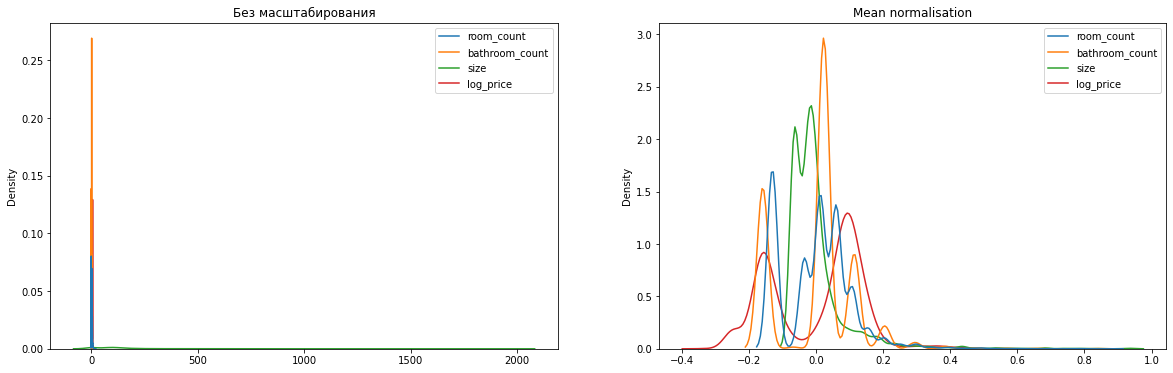

In [11]:
draw_graph(['room_count', 'bathroom_count','size','log_price'], data, data_mn_scale,'Без масштабирования', 'Mean normalisation')

### b) Масштабирование по медиане

In [12]:
rs = RobustScaler()
data_median_scale_arr = rs.fit_transform(data)
data_median_scale = arr_to_df(data_median_scale_arr)
data_median_scale.describe()

,room_count,bathroom_count,size,log_price
count,12748.000000,12748.000000,12748.000000,1.274800e+04
mean,-0.060088,-0.120058,0.237723,-2.328605e-01
std,0.542867,0.632406,1.219040,5.591462e-01
min,-0.750000,-1.000000,-0.635762,-1.590403e+00
25%,-0.750000,-1.000000,-0.635762,-8.141499e-01
50%,0.000000,0.000000,0.000000,1.786765e-16
75%,0.250000,0.000000,0.364238,1.858501e-01
max,4.500000,4.500000,12.615894,2.432844e+00


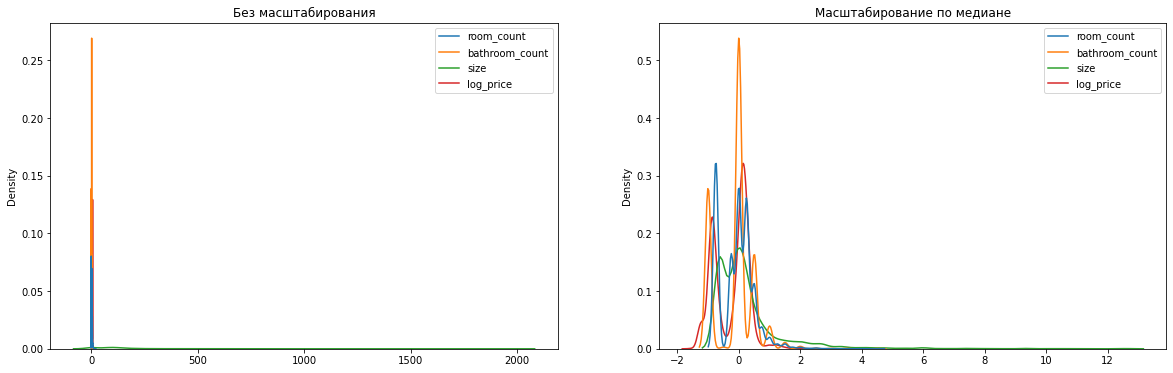

In [13]:
draw_graph(['room_count', 'bathroom_count','size','log_price'], data, data_median_scale,'Без масштабирования', 'Масштабирование по медиане')

### с) Масштабирование по максимальному значению

In [14]:
mas = MaxAbsScaler()
data_max_scale_arr = mas.fit_transform(data)
data_max_scale = arr_to_df(data_max_scale_arr)
data_max_scale.describe()

,room_count,bathroom_count,size,log_price
count,12748.000000,12748.000000,12748.000000,12748.000000
mean,0.087982,0.075988,0.065448,0.397659
std,0.108573,0.126481,0.092037,0.126344
min,-0.050000,-0.100000,-0.000500,0.090909
25%,-0.050000,-0.100000,-0.000500,0.266311
50%,0.100000,0.100000,0.047500,0.450276
75%,0.150000,0.100000,0.075000,0.492270
max,1.000000,1.000000,1.000000,1.000000


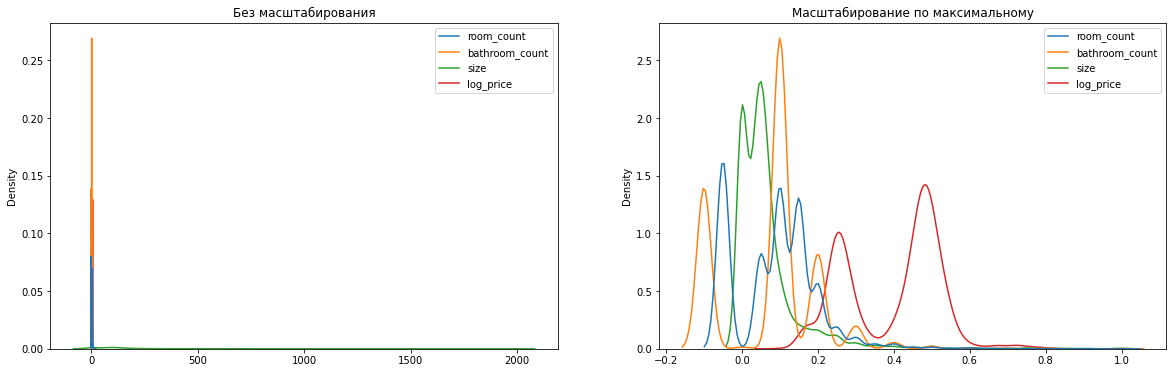

In [15]:
draw_graph(['room_count', 'bathroom_count','size','log_price'], data, data_max_scale,'Без масштабирования', 'Масштабирование по максимальному')

## Обработка выбросов(числовые признаки)

In [16]:
col_list = ['room_count', 'bathroom_count','size','log_price']
def diagnostic_plots(df, variable, title):
    fig, ax = plt.subplots(figsize=(10,7))
    # гистограмма
    plt.subplot(2, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(2, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    # ящик с усами
    plt.subplot(2, 2, 3)
    sns.violinplot(x=df[variable])    
    # ящик с усами
    plt.subplot(2, 2, 4)
    sns.boxplot(x=df[variable])  
    fig.suptitle(title)
    plt.show()

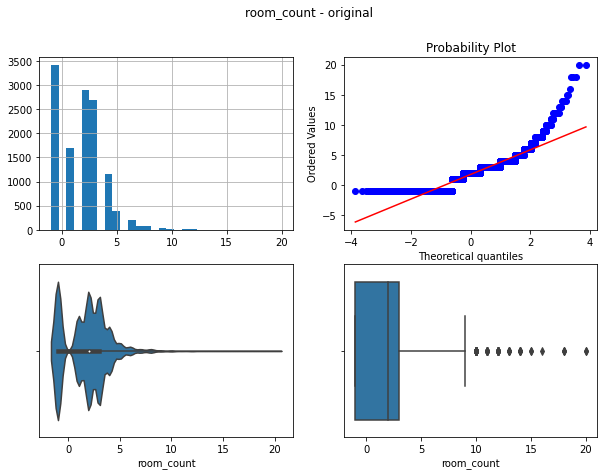

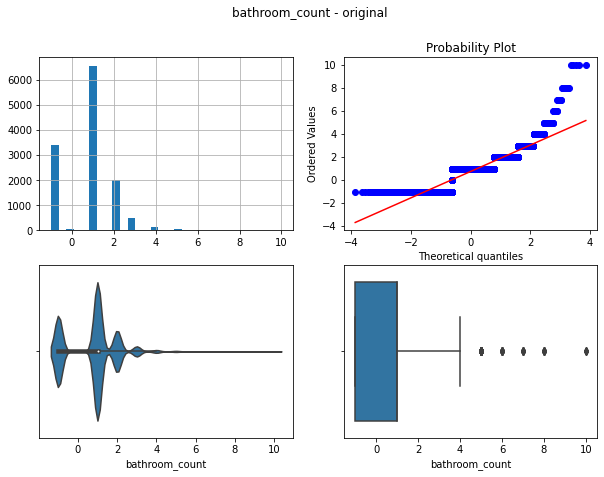

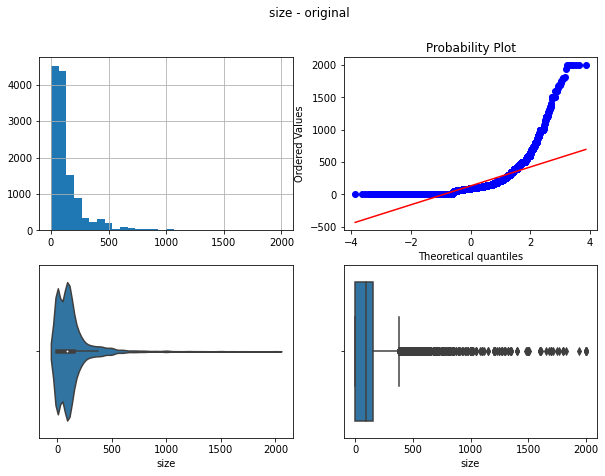

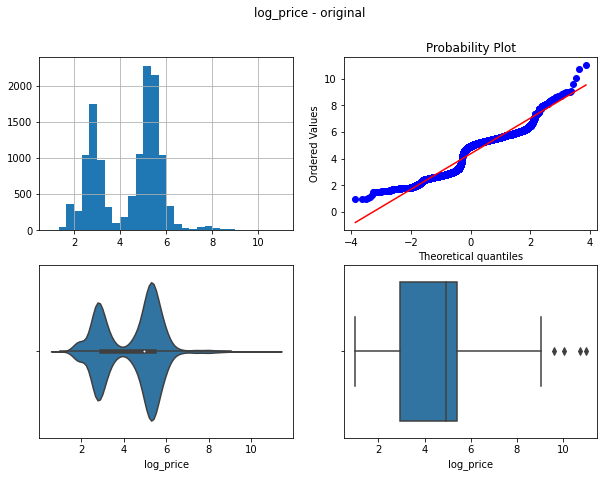

In [17]:
for col in col_list:
    diagnostic_plots(data, col, '{} - original'.format(col))

### Удаление методом межквартильного размаха.

In [18]:
#создадим функцию обнаружения выбросов только для метода межквартильного размаха
def get_outlier_boundaries(df, col):
    K2 = 1.5
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    lower_boundary = df[col].quantile(0.25) - (K2 * IQR)
    upper_boundary = df[col].quantile(0.75) + (K2 * IQR)
    return lower_boundary, upper_boundary 

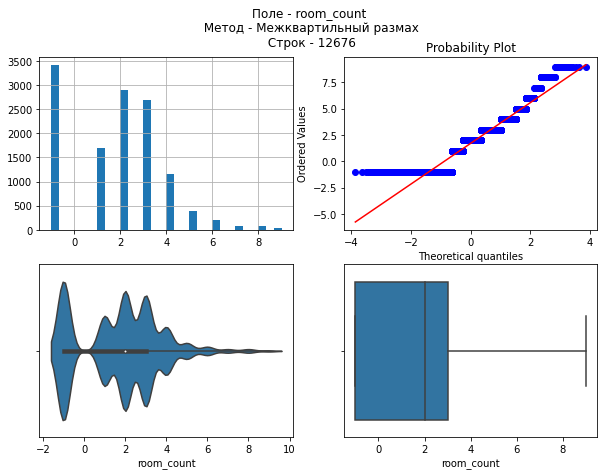

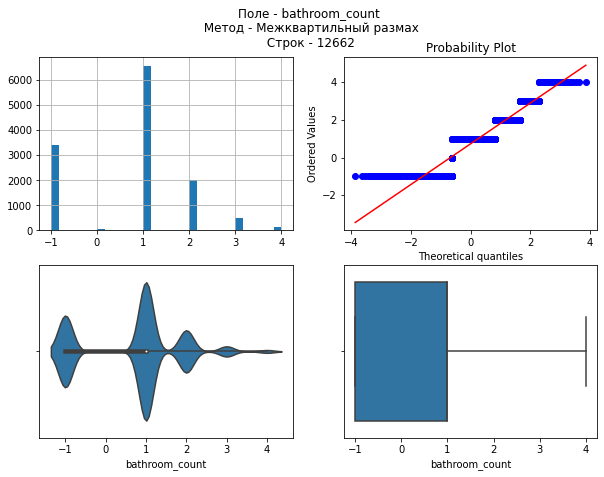

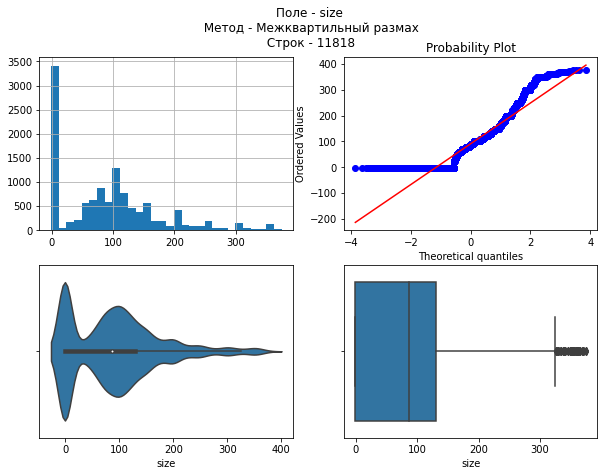

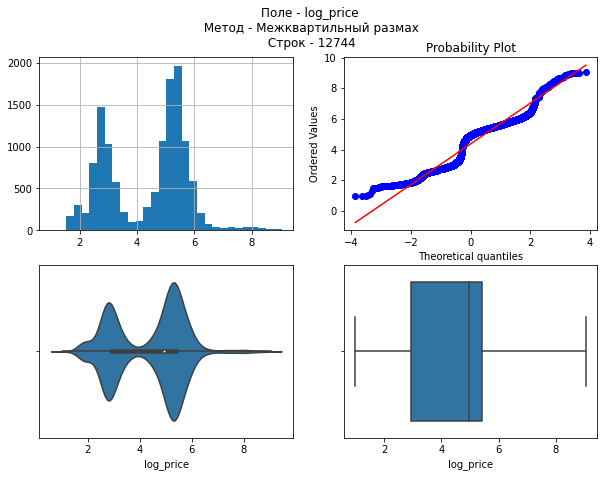

In [19]:
obt = 'Межквартильный размах'
for col in col_list:
    # Вычисление верхней и нижней границы
    lower_boundary, upper_boundary = get_outlier_boundaries(data, col)
    # Флаги для удаления выбросов
    outliers_temp = np.where(data[col] > upper_boundary, True, 
                            np.where(data[col] < lower_boundary, True, False))
    # Удаление данных на основе флага
    data_trimmed = data.loc[~(outliers_temp), ]  
    title = 'Поле - {}\n Метод - {}\n Строк - {}'.format(col, obt, data_trimmed.shape[0])
    diagnostic_plots(data_trimmed, col, title)

### Замена выбросов методом трёх сигм

In [20]:
def get_outlier_boundaries_sigm(df, col):
    K1 = 3
    lower_boundary = df[col].mean() - (K1 * df[col].std())
    upper_boundary = df[col].mean() + (K1 * df[col].std())
    return lower_boundary, upper_boundary 

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27640\2915231609.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = np.where(data[col] > upper_boundary, upper_boundary,


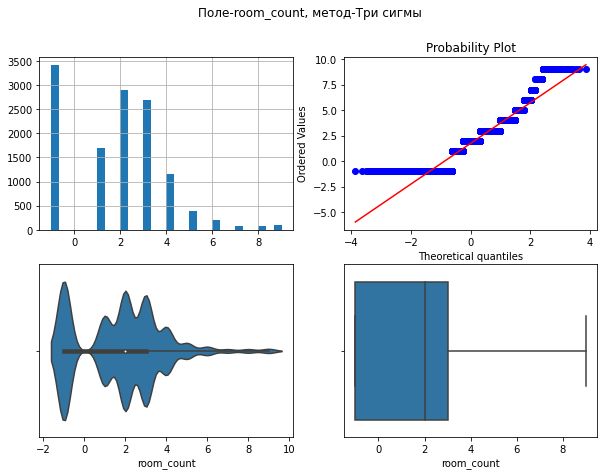

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27640\2915231609.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = np.where(data[col] > upper_boundary, upper_boundary,


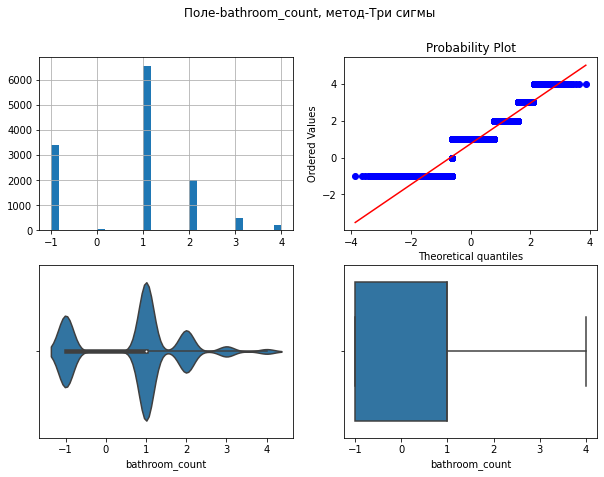

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27640\2915231609.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = np.where(data[col] > upper_boundary, upper_boundary,


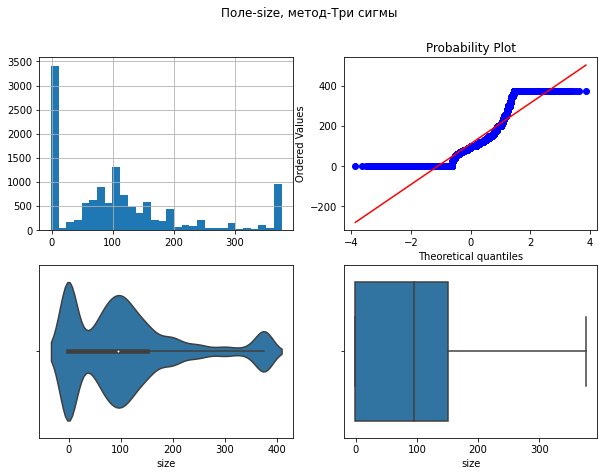

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27640\2915231609.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = np.where(data[col] > upper_boundary, upper_boundary,


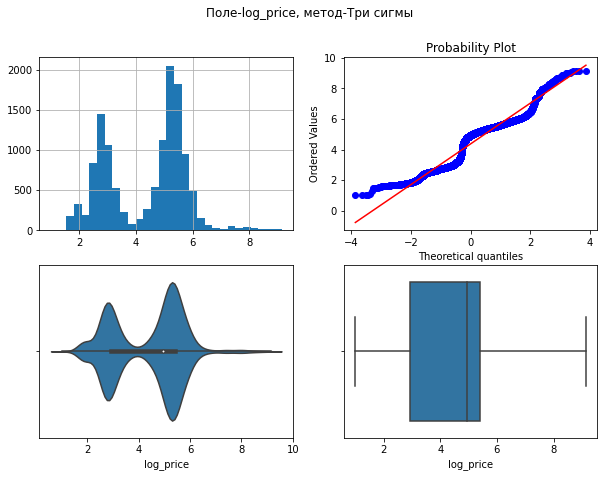

In [21]:
obt2 = 'Три сигмы'
for col in col_list:
        # Вычисление верхней и нижней границы
        lower_boundary, upper_boundary = get_outlier_boundaries(data, col)
        # Изменение данных
        data[col] = np.where(data[col] > upper_boundary, upper_boundary, 
                                 np.where(data[col] < lower_boundary, lower_boundary, data[col]))
        title = 'Поле-{}, метод-{}'.format(col, obt2)
        diagnostic_plots(data, col, title)

## Обработка нестандартных признаков

In [22]:
data_in = pd.read_csv('data/news.csv', sep = ',')

In [23]:
data_input = data_in.iloc[0:2000, :]

In [24]:
data_input

,datetime,title,content,category,url
0,2010-01-01 00:49:00,Enige Litouwse kerncentrale dicht,De enige kerncentrale van Litouwen is oudjaars...,Buitenland,https://nos.nl/artikel/126231-enige-litouwse-k...
1,2010-01-01 02:08:00,Spanje eerste EU-voorzitter onder nieuw verdrag,Spanje is met ingang van vandaag voorzitter va...,Buitenland,https://nos.nl/artikel/126230-spanje-eerste-eu...
2,2010-01-01 02:09:00,Fout justitie in Blackwater-zaak,Vijf werknemers van het omstreden Amerikaanse ...,Buitenland,https://nos.nl/artikel/126233-fout-justitie-in...
3,2010-01-01 05:14:00,"Museumplein vol, minder druk in Rotterdam",Het Oud en Nieuwfeest op het Museumplein in Am...,Binnenland,https://nos.nl/artikel/126232-museumplein-vol-...
4,2010-01-01 05:30:00,Obama krijgt rapporten over aanslag,President Obama heeft de eerste rapporten gekr...,Buitenland,https://nos.nl/artikel/126236-obama-krijgt-rap...
...,...,...,...,...,...
1995,2010-02-24 11:59:00,Hoge boetes voor aspergeteelster,Een aspergeteelster uit Someren in Noord-Braba...,Binnenland,https://nos.nl/artikel/139429-hoge-boetes-voor...
1996,2010-02-24 12:46:00,'Dit zijn de angstscenario's van een coach',Het ging goed mis gisteravond op de tien kilom...,Buitenland,https://nos.nl/artikel/139433-dit-zijn-de-angs...
1997,2010-02-24 13:00:00,Tragedie op Terpstra's laatste Spelen,"Door Martijn Bink en Mattijs van de Wiel ""Vand...",Buitenland,https://nos.nl/artikel/139551-tragedie-op-terp...
1998,2010-02-24 14:06:00,Relletjes bij staking Griekenland,In Athene zijn vechtpartijen tussen betogers e...,Buitenland,https://nos.nl/artikel/139452-relletjes-bij-st...


In [25]:
#def substr_in_url(substr):
    #lsubstr = substr.lower()
    #return data_load.apply(lambda x: 1 if lsubstr in x['url'].lower() else 0, axis=1)

In [26]:
#data_load['is_get'] = substr_in_url('GET')
#data_load['is_php'] = substr_in_url('PHP')
#data_load['is_js'] = substr_in_url('JS')
#data_load['is_woff'] = substr_in_url('WOFF')
#url_features = ['is_get', 'is_php', 'is_js', 'is_woff']

Обработаем признак даты и времени.

In [27]:
#приводим колонку с датой и временем к форме, понятной Datetime
data_input['datetime'] = data_input.apply(lambda x: pd.to_datetime(x['datetime'], format='%Y-%m-%d %H:%M:%S'), axis=1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27640\1421213694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_input['datetime'] = data_input.apply(lambda x: pd.to_datetime(x['datetime'], format='%Y-%m-%d %H:%M:%S'), axis=1)


In [28]:
# День
data_input['day'] = data_input['datetime'].dt.day
# Месяц
data_input['month'] = data_input['datetime'].dt.month
# Год
data_input['year'] = data_input['datetime'].dt.year
# Часы
data_input['hour'] = data_input['datetime'].dt.hour
#Минуты
data_input['minute'] = data_input['datetime'].dt.minute
#Секунды
data_input['second'] = data_input['datetime'].dt.second
#Неделя года
data_input['week'] = data_input['datetime'].dt.isocalendar().week
#Квартал
data_input['quarter'] = data_input['datetime'].dt.quarter
#День недели 
data_input['dayofweek'] = data_input['datetime'].dt.dayofweek
#Выходной день
data_input['day_name'] = data_input['datetime'].dt.day_name()
#data_load['is_holiday'] = data.apply(lambda x: 1 if x['dt'].dayofweek in [5,6] else 0, axis=1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27640\377714258.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_input['day'] = data_input['datetime'].dt.day
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27640\377714258.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_input['month'] = data_input['datetime'].dt.month
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27640\377714258.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [29]:
# Создадим масштабируемые признаки для дальнейших экспериментов
dt_features = ['year', 'day', 'month', 'hour', 'minute', 'second', 'week', 'quarter', 'dayofweek']
dt_features_scaled = []
for f in dt_features:
    f_new = str(f + '_scaled')
    dt_features_scaled.append(f_new)
    data_input[f_new] = MinMaxScaler().fit_transform(data_input[[f]])
dt_features_scaled

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27640\1824856256.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_input[f_new] = MinMaxScaler().fit_transform(data_input[[f]])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27640\1824856256.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_input[f_new] = MinMaxScaler().fit_transform(data_input[[f]])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27640\1824856256.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

['year_scaled',
 'day_scaled',
 'month_scaled',
 'hour_scaled',
 'minute_scaled',
 'second_scaled',
 'week_scaled',
 'quarter_scaled',
 'dayofweek_scaled']

In [30]:
#функция кодировки значения синусом или косинусом
def round_code(v, T, cos_flag = True):
    x = 2*np.pi*v/T
    if cos_flag:
        return np.cos(x)
    else:
        return np.sin(x)

In [31]:
# Опеределим периоды для признаков
for f in dt_features:
    print(f, data_input[f].min(), data_input[f].max())

year 2010 2010
day 1 31
month 1 2
hour 0 23
minute 0 59
second 0 0
week 1 53
quarter 1 1
dayofweek 0 6


In [37]:
dt_features_periods = [0, 31, 12, 24, 60, 60, 52, 4, 7]

In [33]:
#Датафрейм большой и при его фрагментации нам попались только значения из 2010 года, поэтому колонку года не кодируем
# объявлем dt_features_round пустым, чтобы инициировать массив для дальнейшей работы с ним
dt_features_round = [] 

In [34]:
%%time
# Построим отображение признаков на круг, год пропускаем
for f,p in zip(dt_features[1:], dt_features_periods[1:]):
    f_cos = str(f + '_cos')
    f_sin = str(f + '_sin')
    data_input[f_cos] = data_input.apply(lambda x: round_code(x[f], p), axis=1)
    data_input[f_sin] = data_input.apply(lambda x: round_code(x[f], p, False), axis=1)
    dt_features_round.append(f_cos)
    dt_features_round.append(f_sin)
dt_features_round    

<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

CPU times: total: 953 ms
Wall time: 954 ms


<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['day_cos',
 'day_sin',
 'month_cos',
 'month_sin',
 'hour_cos',
 'hour_sin',
 'minute_cos',
 'minute_sin',
 'second_cos',
 'second_sin',
 'week_cos',
 'week_sin',
 'quarter_cos',
 'quarter_sin',
 'dayofweek_cos',
 'dayofweek_sin']

In [36]:
data_input

,datetime,title,content,category,url,day,month,year,hour,minute,...,minute_cos,minute_sin,second_cos,second_sin,week_cos,week_sin,quarter_cos,quarter_sin,dayofweek_cos,dayofweek_sin
0,2010-01-01 00:49:00,Enige Litouwse kerncentrale dicht,De enige kerncentrale van Litouwen is oudjaars...,Buitenland,https://nos.nl/artikel/126231-enige-litouwse-k...,1,1,2010,0,49,...,0.406737,-9.135455e-01,1.0,0.0,0.992709,0.120537,6.123234e-17,1.0,-0.900969,-0.433884
1,2010-01-01 02:08:00,Spanje eerste EU-voorzitter onder nieuw verdrag,Spanje is met ingang van vandaag voorzitter va...,Buitenland,https://nos.nl/artikel/126230-spanje-eerste-eu...,1,1,2010,2,8,...,0.669131,7.431448e-01,1.0,0.0,0.992709,0.120537,6.123234e-17,1.0,-0.900969,-0.433884
2,2010-01-01 02:09:00,Fout justitie in Blackwater-zaak,Vijf werknemers van het omstreden Amerikaanse ...,Buitenland,https://nos.nl/artikel/126233-fout-justitie-in...,1,1,2010,2,9,...,0.587785,8.090170e-01,1.0,0.0,0.992709,0.120537,6.123234e-17,1.0,-0.900969,-0.433884
3,2010-01-01 05:14:00,"Museumplein vol, minder druk in Rotterdam",Het Oud en Nieuwfeest op het Museumplein in Am...,Binnenland,https://nos.nl/artikel/126232-museumplein-vol-...,1,1,2010,5,14,...,0.104528,9.945219e-01,1.0,0.0,0.992709,0.120537,6.123234e-17,1.0,-0.900969,-0.433884
4,2010-01-01 05:30:00,Obama krijgt rapporten over aanslag,President Obama heeft de eerste rapporten gekr...,Buitenland,https://nos.nl/artikel/126236-obama-krijgt-rap...,1,1,2010,5,30,...,-1.000000,5.665539e-16,1.0,0.0,0.992709,0.120537,6.123234e-17,1.0,-0.900969,-0.433884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2010-02-24 11:59:00,Hoge boetes voor aspergeteelster,Een aspergeteelster uit Someren in Noord-Braba...,Binnenland,https://nos.nl/artikel/139429-hoge-boetes-voor...,24,2,2010,11,59,...,0.994522,-1.045285e-01,1.0,0.0,0.568065,0.822984,6.123234e-17,1.0,-0.222521,0.974928
1996,2010-02-24 12:46:00,'Dit zijn de angstscenario's van een coach',Het ging goed mis gisteravond op de tien kilom...,Buitenland,https://nos.nl/artikel/139433-dit-zijn-de-angs...,24,2,2010,12,46,...,0.104528,-9.945219e-01,1.0,0.0,0.568065,0.822984,6.123234e-17,1.0,-0.222521,0.974928
1997,2010-02-24 13:00:00,Tragedie op Terpstra's laatste Spelen,"Door Martijn Bink en Mattijs van de Wiel ""Vand...",Buitenland,https://nos.nl/artikel/139551-tragedie-op-terp...,24,2,2010,13,0,...,1.000000,0.000000e+00,1.0,0.0,0.568065,0.822984,6.123234e-17,1.0,-0.222521,0.974928
1998,2010-02-24 14:06:00,Relletjes bij staking Griekenland,In Athene zijn vechtpartijen tussen betogers e...,Buitenland,https://nos.nl/artikel/139452-relletjes-bij-st...,24,2,2010,14,6,...,0.809017,5.877853e-01,1.0,0.0,0.568065,0.822984,6.123234e-17,1.0,-0.222521,0.974928


## Отбор признаков

In [91]:
data_class = pd.read_csv('data/glass.csv', sep=",")
#data_data = data_class.iloc[:, 2:23] #data_data = data_class.iloc[:, 1:22]
#data_targ = data_class[['class']]
#data_data
data_class.shape

(214, 10)

In [92]:
data_class.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [93]:
data_data = data_class.iloc[:, 0:9] #data_data = data_class.iloc[:, 1:22]
data_targ = data_class[['Type']]
data_data

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0
...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0


### Filter method

In [94]:
data_class['Fe'].unique()

array([0.  , 0.26, 0.11, 0.24, 0.17, 0.07, 0.19, 0.14, 0.22, 0.06, 0.3 ,
       0.16, 0.1 , 0.09, 0.31, 0.03, 0.12, 0.32, 0.15, 0.2 , 0.34, 0.28,
       0.08, 0.29, 0.21, 0.18, 0.25, 0.35, 0.37, 0.51, 0.05, 0.01])

In [95]:
data_class['RI'].unique()

array([1.52101, 1.51761, 1.51618, 1.51766, 1.51742, 1.51596, 1.51743,
       1.51756, 1.51918, 1.51755, 1.51571, 1.51763, 1.51589, 1.51748,
       1.51784, 1.52196, 1.51911, 1.51735, 1.5175 , 1.51966, 1.51736,
       1.51751, 1.5172 , 1.51764, 1.51793, 1.51721, 1.51768, 1.51747,
       1.51775, 1.51753, 1.51783, 1.51567, 1.51909, 1.51797, 1.52213,
       1.51779, 1.5221 , 1.51786, 1.519  , 1.51869, 1.52667, 1.52223,
       1.51898, 1.5232 , 1.51926, 1.51808, 1.51837, 1.51778, 1.51769,
       1.51215, 1.51824, 1.51754, 1.51905, 1.51977, 1.52172, 1.52227,
       1.52099, 1.52152, 1.523  , 1.51574, 1.51848, 1.51593, 1.51631,
       1.5159 , 1.51645, 1.51627, 1.51613, 1.51592, 1.51646, 1.51594,
       1.51409, 1.51625, 1.51569, 1.5164 , 1.51841, 1.51605, 1.51588,
       1.51629, 1.5186 , 1.51689, 1.51811, 1.51655, 1.5173 , 1.5182 ,
       1.52725, 1.5241 , 1.52475, 1.53125, 1.53393, 1.52222, 1.51818,
       1.52664, 1.52739, 1.52777, 1.51892, 1.51847, 1.51846, 1.51829,
       1.51708, 1.51

In [99]:
data_copy = data_data.iloc[:, 3:8]

In [100]:
# удаление константных и псевдоконстантных признаков
selector_fm = VarianceThreshold(threshold = 0.15)
selector_fm.fit(data_copy)
selector_fm.variances_

array([0.24810537, 0.59711782, 0.42336657, 2.01590152, 0.24607173])

In [101]:
selector_fm.transform(data_copy)

array([[1.100e+00, 7.178e+01, 6.000e-02, 8.750e+00, 0.000e+00],
       [1.360e+00, 7.273e+01, 4.800e-01, 7.830e+00, 0.000e+00],
       [1.540e+00, 7.299e+01, 3.900e-01, 7.780e+00, 0.000e+00],
       ...,
       [2.020e+00, 7.342e+01, 0.000e+00, 8.440e+00, 1.640e+00],
       [1.940e+00, 7.361e+01, 0.000e+00, 8.480e+00, 1.570e+00],
       [2.080e+00, 7.336e+01, 0.000e+00, 8.620e+00, 1.670e+00]])

Была удалена колонка содержания железа. 

### Wrapper method

In [112]:
#Sequential Forward Selection


X = data_data
targ_y = data_targ
y = np.ravel(targ_y)
feature_names = ('Refractive index', 'Sodium', 'Magnesium', 'Aluminium', 'Silica', 'Potassium', 'Calcium', 'Barium', 'Iron')

knn = KNeighborsClassifier(n_neighbors=4)

sfs1 = SFS(knn, 
           k_features=8, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=0)

sfs1 = sfs1.fit(X, y, custom_feature_names=feature_names)
sfs1.subsets_


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished

[2022-04-06 00:46:44] Features: 1/8 -- score: 0.6822429906542056[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished

[2022-04-06 00:46:44] Features: 2/8 -- score: 0.7476635514018691[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s finished

[2022-04-06 00:46:44] Features: 3/8 -- score: 0.7710280373831776[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 

{1: {'feature_idx': (3,),
  'cv_scores': array([0.68224299]),
  'avg_score': 0.6822429906542056,
  'feature_names': ('Aluminium',)},
 2: {'feature_idx': (2, 3),
  'cv_scores': array([0.74766355]),
  'avg_score': 0.7476635514018691,
  'feature_names': ('Magnesium', 'Aluminium')},
 3: {'feature_idx': (2, 3, 6),
  'cv_scores': array([0.77102804]),
  'avg_score': 0.7710280373831776,
  'feature_names': ('Magnesium', 'Aluminium', 'Calcium')},
 4: {'feature_idx': (2, 3, 5, 6),
  'cv_scores': array([0.81775701]),
  'avg_score': 0.8177570093457944,
  'feature_names': ('Magnesium', 'Aluminium', 'Potassium', 'Calcium')},
 5: {'feature_idx': (0, 2, 3, 5, 6),
  'cv_scores': array([0.81775701]),
  'avg_score': 0.8177570093457944,
  'feature_names': ('Refractive index',
   'Magnesium',
   'Aluminium',
   'Potassium',
   'Calcium')},
 6: {'feature_idx': (0, 1, 2, 3, 5, 6),
  'cv_scores': array([0.81775701]),
  'avg_score': 0.8177570093457944,
  'feature_names': ('Refractive index',
   'Sodium',
   'Ma

In [113]:
print('Best subset (corresponding names): ', sfs1.k_feature_names_)

Best subset (corresponding names):  ('Refractive index', 'Sodium', 'Magnesium', 'Aluminium', 'Potassium', 'Calcium', 'Barium', 'Iron')


Признак содержания кремния не вошёл в лучшие результаты для модели

### Embedded method

Воспользуемся моделью логистической регрессии, поскольку имеем задачу классификации: 

In [114]:

x_val = X.values.tolist()

In [115]:
e_lr1 = LogisticRegression(C= 1000, solver='sag', penalty='l2', max_iter = 5300)
e_lr1.fit(x_val, y)
e_lr1.coef_

array([[-8.86388536e-02, -1.09019926e+00,  2.09116409e+00,
        -3.76078373e+00,  1.53850398e-01,  2.85248776e-03,
         4.61957399e-01,  7.67171503e-01, -6.96559946e-01],
       [ 1.71548520e-01, -3.15750082e-01,  5.26470743e-01,
        -1.46356660e-01, -7.76262033e-03,  1.39110916e+00,
         5.51582432e-01,  1.17023994e+00,  2.16672392e+00],
       [-2.49241501e-02,  3.53495278e-02,  1.77604756e+00,
        -1.63895777e+00, -1.01393377e-01, -6.54039755e-01,
         5.46529031e-01, -3.44259488e-01,  1.09686489e-01],
       [ 6.61382435e-02, -1.07075727e+00, -9.57281499e-01,
         4.40335077e+00,  6.71671650e-02,  1.92603855e+00,
         3.94878664e-01, -2.42919786e-01, -4.45621283e-01],
       [-1.30922761e-01,  1.69772128e+00, -1.13727199e+00,
         1.70121556e-01, -1.71564241e-01, -3.73898251e+00,
        -7.27391927e-01, -2.56983928e+00, -7.69888213e-01],
       [ 6.79900094e-03,  7.43635810e-01, -2.29912891e+00,
         9.72625843e-01,  5.97026744e-02,  1.073022

In [117]:
#только четыре признака из восьми оказались хорошими!
sel_e_lr1 = SelectFromModel(e_lr1)
sel_e_lr1.fit(x_val, y)
list(zip(feature_names, sel_e_lr1.get_support()))

[('Refractive index', False),
 ('Sodium', False),
 ('Magnesium', True),
 ('Aluminium', True),
 ('Silica', False),
 ('Potassium', True),
 ('Calcium', False),
 ('Barium', True),
 ('Iron', False)]

Оказались хорошими для модели признаки содержания в стекле магния, алюминия, калия, бария.